In [1]:
####

In [2]:
import torch
from torch.utils.data import DataLoader , Dataset
from torchvision import datasets , transforms
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchvision.utils import make_grid

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
alpha = 1
eps = 60
scale = 1


In [43]:
def show_tensor_images(image_tensor, num_images=2, size=(1 , 28 , 28)):
  image_shifted = image_tensor
  image_unflat = image_shifted.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

In [44]:
class Model(nn.Module):
    def __init__(self):
        super(Model , self).__init__()

        self.conv1 = nn.Conv2d(1 , 10 , kernel_size = 5)
        self.conv2 = nn.Conv2d(10 , 20 , kernel_size=5)
        self.dropout2d = nn.Dropout2d()

        self.fc1 = nn.Linear(320 , 50)
        self.fc2 = nn.Linear(50 , 10)
        self.relu = nn.ReLU()
        self.dropout1d = nn.Dropout()
        self.softmax = nn.Softmax()
        self.maxpool = nn.MaxPool2d(kernel_size=2 , stride=2)

    def forward(self , x):
        x = self.relu(self.maxpool(self.conv1(x)))
        x = self.relu(self.dropout2d(self.maxpool(self.conv2(x))))
        x = x.view(-1 , 320)
        x = self.fc1(x)
        x = self.softmax(self.fc2(x))
        return x

In [45]:
model = Model().to(device)
x = torch.randn(2 , 1 , 28 , 28).to(device)
z = model(x)
z.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([2, 10])

In [46]:

test_dataloader = DataLoader(
    datasets.MNIST(
        '../data' , 
        train = False , 
        transform = transforms.Compose([transforms.ToTensor()]) , 
        download = True
    ) , 
    batch_size = 1 , 
    shuffle = True
)

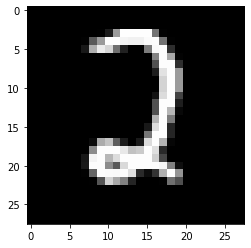

tensor([2])


In [47]:
for x , y in test_dataloader:
    show_tensor_images(x)
    print(y)
    break

In [48]:
pretrained_model = '/content/drive/MyDrive/lenet_mnist_model.pth'

In [49]:
model = Model().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location=device))

<All keys matched successfully>

In [50]:
def iterative_fgsm(model , loss , image , label , scale , eps , alpha , iters = 0):

    image = image.to(device)
    label = label.to(device)
    clamp_max = 255

    if iters == 0:
        iters = int(min(eps + 4, 1.25*eps))
    if scale :
        eps = eps / 255
        clamp_max = clamp_max / 255
    
    for i in range(iters):
        image.requires_grad = True
        output = model(image)
        
        model.zero_grad()
        model_loss = loss(output , label)
        model_loss.backward()

        adversarial_image = image + alpha * image.grad.sign()
        # a = max{0, X-eps}
        a = torch.clamp(image - eps, min=0)
        # b = max{a, X'}
        b = (adversarial_image>=a).float()*adversarial_image + (a>adversarial_image).float()*a
        # c = min{X+eps, b}
        c = (b > image+eps).float()*(image+eps) + (image+eps >= b).float()*b
        # d = min{255, c}
        images = torch.clamp(c, max=clamp_max).detach_()
        return images

In [51]:
loss = nn.CrossEntropyLoss()

In [63]:
def attack(model , dataloader):
    model.eval()
    correct = 0
    total = 0

    for image , label in dataloader:
        label = label.to(device)
        image = image.to(device)
        adversarial_image = iterative_fgsm(model , loss , image , label , scale , eps , alpha)
        output = model(adversarial_image)
        _ , output = torch.max(output.data , 1)
        total += 1
        correct +=  (output == label).sum()
        #show_tensor_images(adversarial_image)
    print(total , correct , total-correct)

In [64]:
attack(model , test_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


10000 tensor(2281) tensor(7719)


In [65]:
def test(model , dataloader , epsilon , device):
    adv_examples = []
    correct = 0

    for data , target in dataloader:
        data , target = data.to(device) , target.to(device)

        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1 , keepdim = True)[1]

        if init_pred != target:
            continue
        

       
        adversarial_image = iterative_fgsm(model , loss , data , target , scale , eps , alpha )

        output = model(adversarial_image)
        final_output = output.max(1 , keepdim = True)[1]

        if final_output.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = adversarial_image.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_output.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = adversarial_image.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_output.item(), adv_ex) )

    final_accuracy = correct/float(len(dataloader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(dataloader), final_accuracy))
    return final_accuracy , adv_examples

In [66]:
epsilon = [10 , 20 , 30 , 40 , 50 , 60 , 70]

In [68]:
accuracies = []
examples = []
for eps in epsilon:
    acc, ex = test(model, test_dataloader, eps , device)
    accuracies.append(acc)
    examples.append(ex)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 10	Test Accuracy = 9316 / 10000 = 0.9316
Epsilon: 20	Test Accuracy = 8533 / 10000 = 0.8533
Epsilon: 30	Test Accuracy = 7291 / 10000 = 0.7291
Epsilon: 40	Test Accuracy = 5647 / 10000 = 0.5647
Epsilon: 50	Test Accuracy = 3875 / 10000 = 0.3875
Epsilon: 60	Test Accuracy = 2281 / 10000 = 0.2281
Epsilon: 70	Test Accuracy = 1146 / 10000 = 0.1146


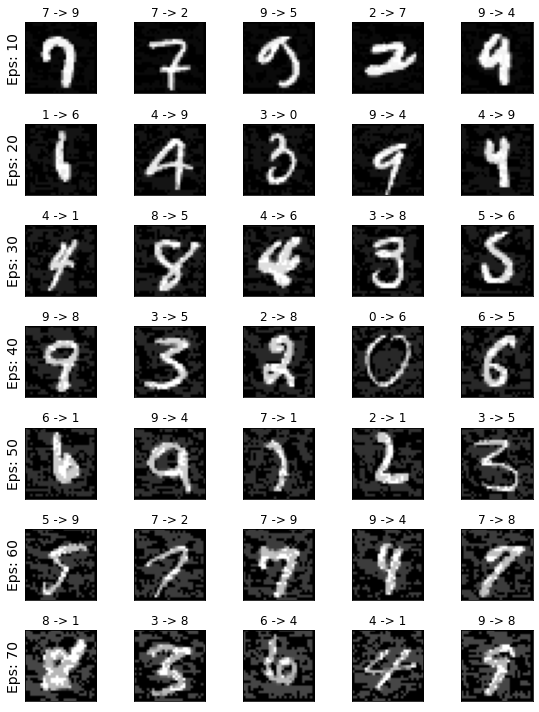

In [71]:

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilon)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilon),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilon[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()